In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from nltk.classify import NaiveBayesClassifier
import contractions
import re

In [3]:
data = pd.read_csv("mbti_1.csv")
types = np.unique(np.array(data['type']))

In [7]:
data.posts[3]

"'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub,   Long time no see.  Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences, like everything in humanity.|||Draco Malfoy also. I'd say he's either 358 or 368.|||I'm either 358 or 385, though in which stacking to me is a somewhat arbitrary distinction to make as I believe that the core indicates primary motivation and has a hand in every action. Therefore, a...|||I'm not particularly introverted or extraverted, personally. That said, I would say I'm somewhat unphased by either social interactions or being alone. What I'd say I crave more so than anything is...|||Dear Type 9 INFP,  Your absolute admiration of me is refreshing. You're a great girlfriend and I wish we both 

# Data Cleaning

We first begin to clean the data by removing the stop words from the data along with any information about the links that the users post. 

In [3]:
data['posts'] = data['posts'].str.replace('http\S+|www.\S+', '', case=False)

In [4]:
data['posts'] = data['posts'].apply(lambda x: ' '.join([re.sub(r"[^A-Za-z0-9(),!?\'\`\.]", " ", word) for word in x.split()]))

In [5]:
data['posts']= data['posts'].apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

In [6]:
data['posts'] = data['posts'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))

In [7]:
stop = stopwords.words('english')
data['posts'] = data['posts'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [8]:
lemmatizer = nltk.stem.WordNetLemmatizer()
data['posts'] = data['posts'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))

In [10]:
data.to_csv('preprocessed.csv')

# Data Preprocessing

This step involves tokenizing the words and padding 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
df = pd.read_csv("preprocessed.csv")
from keras.preprocessing import sequence
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from nltk.classify import NaiveBayesClassifier
import contractions
import re
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,RNN,GRU, Dropout
from keras.datasets import imdb
import matplotlib.pyplot as plt
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [2]:
df.posts = df.posts.str.replace('\d+','')
df.posts[3]

"wouldear intp, enjoy conversation day. esoteric gabbing nature universe idea every rule social code arbitrary construct created... dear entj sub, long time see. sincerely, alpha none them. type hurt deep existential ways want part of. probably slide scale depend individual preferences, like everything humanity. draco malfoy also. would say either  . either  , though stack somewhat arbitrary distinction make believe core indicate primary motivation hand every action. therefore, a... particularly introvert extraverted, personally. said, would say somewhat unphased either social interactions alone. would say crave anything is... dear type  infp, absolute admiration refreshing. great girlfriend wish busy schedule could around one another often. keep...  still mean   people. probably see   others today. never understand fascination virtue rarity. so, esfj train also, right? toy idea op extrovert also awhile now, actually. many conversations him, however disincline believe due op much close

In [3]:
df['E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['J'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

In [4]:
X = df['posts']
X = X.str.replace('\d+','')

In [5]:
max_features = 3000
max_review_length = 500

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
x_train = tokenizer.texts_to_sequences(X.values)
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)

In [6]:
embed_dim = 50
lstm_out = 50
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

c:\users\amish\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  after removing the cwd from sys.path.
c:\users\amish\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, dropout=0.2, recurrent_dropout=0.2)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           150000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 170,302
Trainable params: 170,302
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
Y = pd.get_dummies(df['T'].values)
X_train, X_test, Y_train, Y_test = train_test_split(X_train,Y, test_size = 0.2,stratify=Y ,random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6940, 500) (6940, 2)
(1735, 500) (1735, 2)


In [8]:
batch_size = 128
history = model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, validation_split=0.1)

Train on 6246 samples, validate on 694 samples
Epoch 1/3
6246/6246 [==============================] - 22s 4ms/step - loss: 0.6891 - acc: 0.5435 - val_loss: 0.6916 - val_acc: 0.5202
Epoch 2/3
6246/6246 [==============================] - 24s 4ms/step - loss: 0.6499 - acc: 0.6122 - val_loss: 0.6163 - val_acc: 0.6787
Epoch 3/3
6246/6246 [==============================] - 22s 4ms/step - loss: 0.5200 - acc: 0.7574 - val_loss: 0.6156 - val_acc: 0.6859


In [9]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.60
acc: 0.68


In [10]:
y_pred = model.predict(X_test)

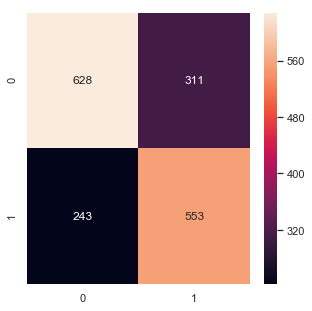

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
Y_test = Y_test.values
#y_pred = y_pred.values


sns.set(rc={'figure.figsize':(5,5)})
#cm = confusion_matrix(y_test,y_pred.round())
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm,annot=True,fmt="d")

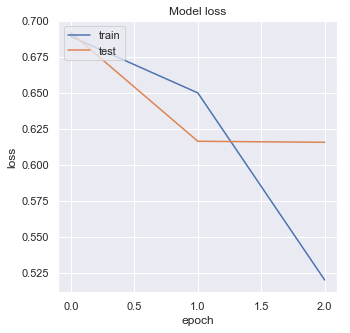

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim(2,3)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
